# Shape compression
The Mapisto database contains geometric information about territories.  
Example : 
```
M 1336.92636280125,441.9225503793691 L 1336.6697191514063,441.9225503793691 L 1336.4130755015626,441.9225503793691 L 1336.1564318517187,441.9225503793691 L 1335.899788201875,441.9225503793691 L 1335.6439497085798,441.66671188607387 L 1335.6431445520311,441.6659067295253 L 1335.387306058736,441.41006823623013 L 1335.387306058736,441.15342458638634 L 1335.3865009021874,441.15261942983784 L 1335.1306624088922,440.8967809365426 L 1335.1306624088922,440.64013728669886 L 1335.1306624088922,440.3834936368551 L 1335.1306624088922,440.1268499870114 L 1335.1306624088922,439.8702063371676 L 1335.1306624088922,439.61356268732385 Z
```
To display the world map, 1 to 10 mB of geometric data are loaded from the server. Resulting in a few seconds latency for every requests.  
To reduce this latency, this notebook tries to compress the data. Let's reduce them to a 1 kilometer precision.
## How much is 1 kilometer here?
Our shapes coordinates are expressed in svg `pt`.  
The world map is $2269.4568$ `pt` wide. The real world is $40 075$ `km` wide.  
Ignoring the earth's curvature, $1$ `km` corresponds to $\frac{2269.4568}{40 075} = 0.0566$`pt`.  
  
Roughly, keeping 1 digit after the comma is enough to allow a $1$ `km` precision

## Load the shapes

In [1]:
import requests

api_endpoint = 'https://api.mapisto.org/state'
res = requests.get(api_endpoint, params={
    "date" : "1918-01-01"
})
print(res)

<Response [200]>


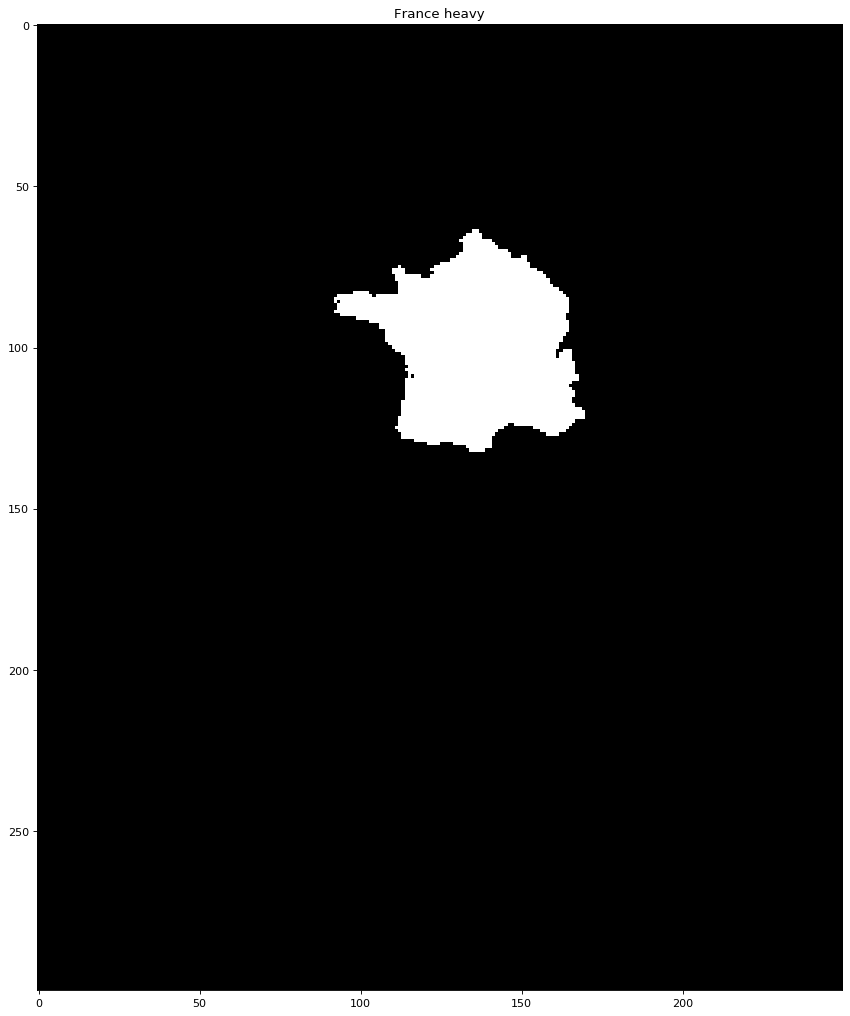

Size of the france's path :  57.221 kB


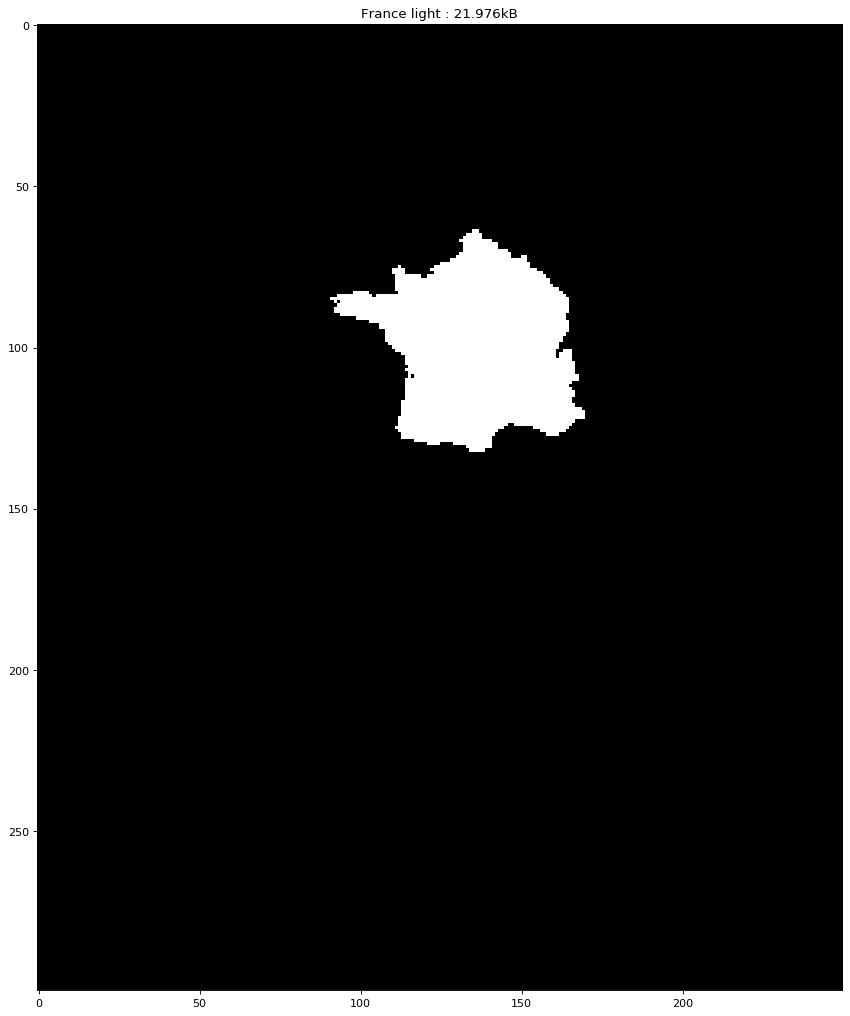

In [82]:
from shapely.geometry import Polygon
import skimage.draw
from shapely.affinity import scale
import matplotlib.pyplot as plt
from svgpath2mpl import parse_path
import numpy as np
import xml.etree.ElementTree as ET



def draw_polygons(img, polygons, color):
    res = img.copy()
    for polygon in polygons :
        coords = np.array(polygon.exterior.coords)
        rr, cc = skimage.draw.polygon(coords[:, 1], coords[:, 0])
        res[rr, cc] = color
    return res

def display_img(img, title="", big=False) : 
    if big : 
        fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

france_path = [state for state in res.json() if state['name']=='France'][0]['territories'][1]
#print(first_territory_path)

polygon_heavy = Polygon(parse_path(first_territory_path).to_polygons()[0])

display_img(draw_polygons(np.zeros((1800, 2500)) , [polygon_heavy], 1)[300:600 , 950:1200], "France heavy", True)


print('Size of the france\'s path : ' , len(france_path)/1000, 'kB')
polygon_light = Polygon(np.around(polygon_heavy.exterior.coords, decimals=1))
to_path = lambda polygon : ET.ElementTree(ET.fromstring(polygon.svg())).getroot().attrib['d'] 

size_light_france = str(len(to_path(polygon_light))/1000)+'kB'
display_img(draw_polygons(np.zeros((1800, 2500)) , [polygon_light], 1)[300:600 , 950:1200], "France light : "+size_light_france, True)

In [83]:
print(france_path[:100])
print(to_path(polygon_light)[:100])

M 1087.9820224528125,432.6833789849941 L 1087.7253788029689,432.6833789849941 L 1087.468735153125,43
M 1088.0,432.7 L 1087.7,432.7 L 1087.5,432.7 L 1087.2,432.7 L 1087.0,432.7 L 1086.7,432.4 L 1086.7,4


In [84]:
coords = polygon_light.exterior.coords
distance = np.zeros((len(coords)-1))
for i in range(len(coords) - 1):
    dist = np.linalg.norm(np.subtract(coords[i], coords[i+1]))
    distance[i] = dist
    if dist < .1 and False:
        print('small distance : ', dist)
        print('between', coords[i], 'and', coords[i+1])
print(len(coords), 'Coordinates in total')
print(len(distance[distance < .1]) , 'useless coords')


1465 Coordinates in total
398 useless coords


light has 1465 points
very light has 267 points


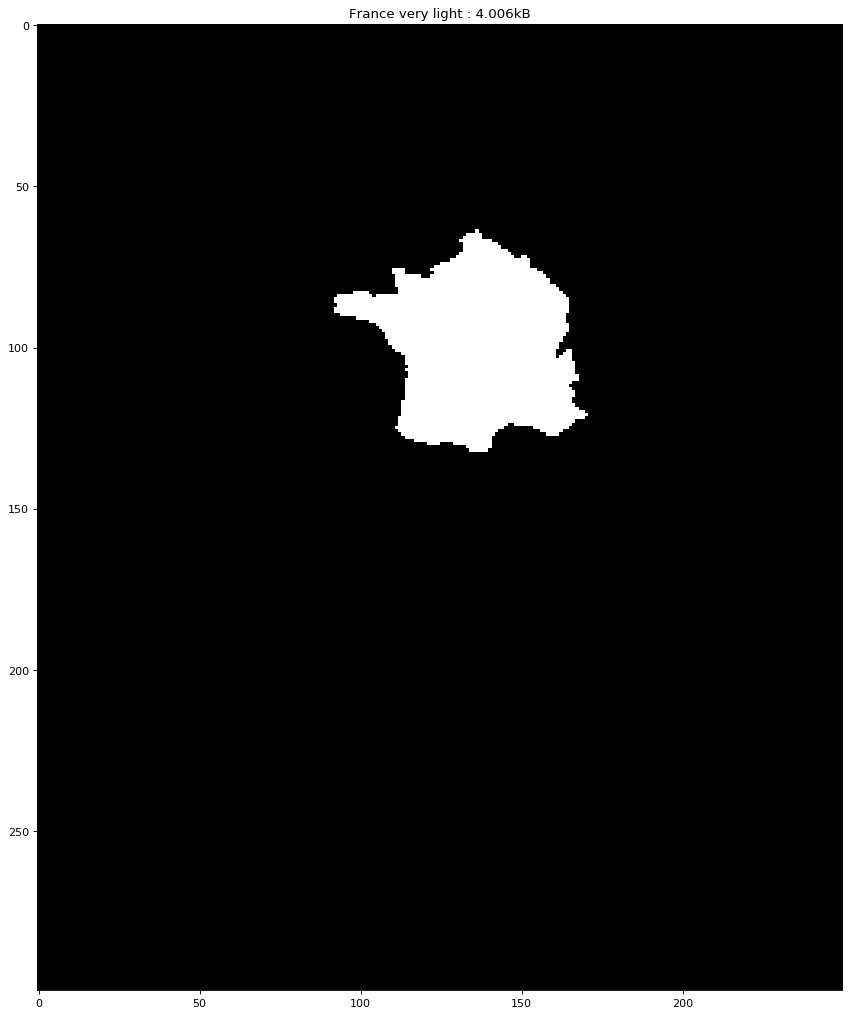

In [109]:
def remove_too_close_coord(polygon, min_distance):
    coords = polygon.exterior.coords
    distance = lambda a, b : np.linalg.norm(np.subtract(a, b))
    res = [coords[0]]
    i=0
    while i < len(coords):
        gap = 1
        try :
            while distance(coords[i], coords[i+gap]) < min_distance:
                gap +=1
            res.append(coords[i+gap])
            
        except IndexError:
            pass
        i+=gap
    try :
        return Polygon(res)
    except ValueError:
        # When there are less than 3 points in res no polygon can be returned
        return None
polygon_very_light = remove_too_close_coord(polygon_light, 1)
print('light has', len(polygon_light.exterior.coords), 'points')
print('very light has', len(polygon_very_light.exterior.coords), 'points')
size_very_light_france = str(len(to_path(polygon_very_light))/1000)+'kB'
display_img(draw_polygons(np.zeros((1800, 2500)) , [polygon_very_light], 1)[300:600 , 950:1200], "France very light : "+size_very_light_france, True)

In [124]:
from math import floor, log

to_path = lambda polygon : ET.ElementTree(ET.fromstring(polygon.svg())).getroot().attrib['d'] 
def compress(path, kilometer_precision):
    point_precision = 2269.4568/40075 * kilometer_precision
    heavy = Polygon(parse_path(path).to_polygons()[0])
    #print('heavy has ', len(heavy.exterior.coords), 'coordinates')
    light = remove_too_close_coord(heavy, point_precision)
    if light==None:
        return None
    #print('light has ', len(light.exterior.coords), 'coordinates')
    if point_precision >= 1 :
        return to_path(Polygon(np.around(light.exterior.coords))).replace('.0', '')
    else :
        nb_decimals = - floor(log(point_precision)/log(10))
        return to_path(Polygon(np.around(light.exterior.coords, decimals=nb_decimals)))

precisions = [1, 5, 10, 20]
print('Precision : None \t size : ', len(france_path)/1000, 'kB')
for precision in precisions:
    print('Precision : ', precision, 'km \t size : ', len(compress(france_path, precision))/1000, 'kB')

Precision : None 	 size :  57.221 kB
Precision :  1 km 	 size :  17.824 kB
Precision :  5 km 	 size :  9.781 kB
Precision :  10 km 	 size :  6.706 kB
Precision :  20 km 	 size :  2.553 kB


## Compress all states at once 

In [125]:
import copy
from tqdm.notebook import tqdm
import json
print('Initial precision : ', len(str(res.json()))/1000, 'kB')
for precision in precisions:
    print('precision : ', precision, 'km')
    state_set = []
    for state in res.json():
        compressed_path = [compress(path, precision) for path in state['territories']]
        state_compressed = dict(state)
        state_compressed['territories'] = [path for path in compressed_path if path ]
        state_set.append(state_compressed)
    print('year size : ', len(str(state_set))/1000, 'kB')
print(state_set)


Initial precision :  1585.401 kB
precision :  1 km
year size :  498.577 kB
precision :  5 km
year size :  274.246 kB
precision :  10 km
year size :  187.911 kB
precision :  20 km
year size :  72.313 kB
[{'color': 'ebc049', 'name': None, 'state_id': 96, 'territories': ['M 1337,427 L 1336,426 L 1335,426 L 1334,426 L 1332,425 L 1331,425 L 1330,425 L 1328,425 L 1327,424 L 1326,424 L 1325,424 L 1324,424 L 1323,423 L 1322,422 L 1321,421 L 1319,420 L 1318,419 L 1317,419 L 1316,418 L 1315,418 L 1314,417 L 1313,417 L 1312,415 L 1311,415 L 1310,415 L 1308,414 L 1308,413 L 1307,412 L 1306,412 L 1304,412 L 1305,411 L 1305,410 L 1306,410 L 1308,410 L 1309,410 L 1310,409 L 1310,408 L 1310,407 L 1311,406 L 1312,405 L 1313,405 L 1314,404 L 1315,404 L 1314,403 L 1313,402 L 1312,401 L 1311,400 L 1312,400 L 1313,399 L 1314,399 L 1315,398 L 1316,398 L 1318,398 L 1319,397 L 1320,396 L 1320,395 L 1320,394 L 1321,393 L 1321,391 L 1321,390 L 1321,389 L 1320,388 L 1320,386 L 1321,385 L 1321,384 L 1322,383 L 13

In [127]:
import json
print(json.dumps(state_set))

[{"color": "ebc049", "name": null, "state_id": 96, "territories": ["M 1337,427 L 1336,426 L 1335,426 L 1334,426 L 1332,425 L 1331,425 L 1330,425 L 1328,425 L 1327,424 L 1326,424 L 1325,424 L 1324,424 L 1323,423 L 1322,422 L 1321,421 L 1319,420 L 1318,419 L 1317,419 L 1316,418 L 1315,418 L 1314,417 L 1313,417 L 1312,415 L 1311,415 L 1310,415 L 1308,414 L 1308,413 L 1307,412 L 1306,412 L 1304,412 L 1305,411 L 1305,410 L 1306,410 L 1308,410 L 1309,410 L 1310,409 L 1310,408 L 1310,407 L 1311,406 L 1312,405 L 1313,405 L 1314,404 L 1315,404 L 1314,403 L 1313,402 L 1312,401 L 1311,400 L 1312,400 L 1313,399 L 1314,399 L 1315,398 L 1316,398 L 1318,398 L 1319,397 L 1320,396 L 1320,395 L 1320,394 L 1321,393 L 1321,391 L 1321,390 L 1321,389 L 1320,388 L 1320,386 L 1321,385 L 1321,384 L 1322,383 L 1323,382 L 1323,381 L 1323,380 L 1323,378 L 1323,377 L 1322,376 L 1321,376 L 1320,376 L 1318,376 L 1317,376 L 1316,375 L 1315,374 L 1314,373 L 1313,373 L 1312,373 L 1310,374 L 1309,374 L 1308,373 L 1307,3